In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "D:/Capstone/Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [3]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [4]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [5]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [6]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [7]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [8]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [9]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [10]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [11]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [12]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'D:/Capstone/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [20]:
# Below path contains all the images
images = 'D:/Capstone/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [21]:
img[:10]

['D:/Capstone/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'D:/Capstone/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'D:/Capstone/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'D:/Capstone/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'D:/Capstone/Flicker8k_Dataset\\1007129816_e794419615.jpg',
 'D:/Capstone/Flicker8k_Dataset\\1007320043_627395c3d8.jpg',
 'D:/Capstone/Flicker8k_Dataset\\1009434119_febe49276a.jpg',
 'D:/Capstone/Flicker8k_Dataset\\1012212859_01547e3f17.jpg',
 'D:/Capstone/Flicker8k_Dataset\\1015118661_980735411b.jpg',
 'D:/Capstone/Flicker8k_Dataset\\1015584366_dfcec3c85a.jpg']

In [22]:
# Below file conatains the names of images to be used in train data
train_images_file = 'D:/Capstone/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [23]:
# Below file conatains the names of images to be used in test data
test_images_file = 'D:/Capstone/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [24]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [25]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [54]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [55]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [56]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [57]:
model.layers[-2]

In [58]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [46]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 3646.8710210323334


In [0]:
# Save the bottleneck train features to disk
with open("/content/drive/My Drive/encoded_train_images1.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

In [59]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 369.76210737228394


In [0]:
# Save the bottleneck test features to disk
with open("/content/drive/My Drive/encoded_test_images1.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

In [50]:
train_features = load(open("/content/drive/My Drive/encoded_train_images1.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
test_features = load(open("/content/drive/My Drive/encoded_test_images1.pkl", "rb"))
print('Photos: train=%d' % len(test_features))

In [60]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [61]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [62]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [63]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [64]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [65]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [36]:
# Load Glove vectors
glove_dir = 'D:/Capstone/Flickr8k_text/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [66]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [67]:
embedding_matrix.shape

(1652, 200)

In [68]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [69]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 200)      330400      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [70]:
model.layers[2]

In [71]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [73]:
#model.load_weights('D:/GitHub/Convergence/model_20.h5')

In [64]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [66]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 1089s 545ms/step - loss: 4.1390
Epoch 1/1
2000/2000 [==============================] - 976s 488ms/step - loss: 3.4265
Epoch 1/1
2000/2000 [==============================] - 960s 480ms/step - loss: 3.2051
Epoch 1/1
2000/2000 [==============================] - 956s 478ms/step - loss: 3.0706
Epoch 1/1
2000/2000 [==============================] - 1026s 513ms/step - loss: 2.9742
Epoch 1/1
2000/2000 [==============================] - 1055s 528ms/step - loss: 2.9023
Epoch 1/1
2000/2000 [==============================] - 958s 479ms/step - loss: 2.8432
Epoch 1/1
2000/2000 [==============================] - 958s 479ms/step - loss: 2.7977
Epoch 1/1
2000/2000 [==============================] - 957s 479ms/step - loss: 2.7563
Epoch 1/1
2000/2000 [==============================] - 957s 478ms/step - loss: 2.7213


In [0]:
with open("/content/drive/My Drive/encoded_test_images1.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [86]:
def beam_search_predictions(photo, beam_index = 3):
    start = [wordtoix["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            e = encoding_test[photo[len(images):]]
            #preds = model.predict([np.array([e]), np.array(par_caps)])
            preds = model.predict([np.array([e]),np.array(par_caps)], verbose=0)
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [111]:
def greedySearch2(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        e = encoding_test[photo[len(images):]]
        yhat = model.predict([np.array([e]),np.array(sequence)], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [112]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [107]:

def predict_captions(photo):
    start_word = ["startseq"]
    while True:
        par_caps = [wordtoix[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_length, padding='post')
        e = encoding_test[photo[len(images):]]
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = ixtoword[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "endseq" or len(start_word) > max_length:
            break
            
    return ' '.join(start_word[1:-1])

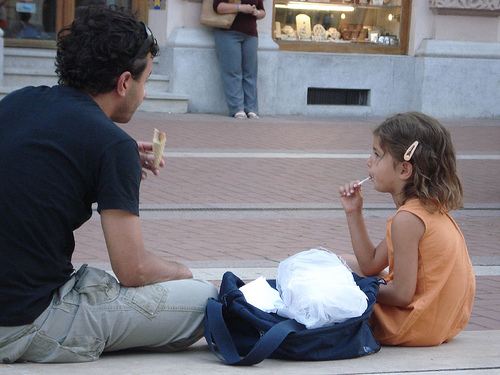

In [122]:
try_image = test_img[100]
Image.open(try_image)

In [123]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Greedy search:', greedySearch2(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))
print ('Beam Search, k=10:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: group of children are sitting on wooden floor and are sitting on the ground
Greedy search: group of children are sitting on wooden floor and are sitting on the ground
Beam Search, k=3: group of children are sitting on wooden floor in front of building
Beam Search, k=5: group of people are sitting on wooden bench in front of white building
Beam Search, k=7: group of people are sitting on wooden bench in front of white building
Beam Search, k=10: group of people are sitting on wooden bench in front of white building


2112921744_92bf706805.jpg


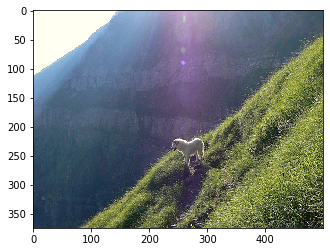

Beam:  white dog is standing on top of mountain
Actual Captions:-
dog on green hillside
dog standing on the side of mountain
dog stands on the side of grassy cliff
fluffy white dog looks down steep grassy embankment
white dog is standing on grassy hillside


In [132]:
z=130
images = 'D:/Capstone/Flicker8k_Dataset/'
pic = list(encoding_test.keys())[z]
print(pic)
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
y=test_img[z]
cand = beam_search_predictions(y).split()
print("Beam: ",beam_search_predictions(y))

test_filename = 'D:/Capstone/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(test_filename)
test_descr = load_clean_descriptions('descriptions.txt', test)
print("Actual Captions:-")
reference = []
for descr in test_descr[pic.split('.')[0]]:
  reference.append(descr.replace('startseq ','').replace(' endseq','').split())
  print(descr.replace('startseq ','').replace(' endseq',''))

In [133]:
cand

['white', 'dog', 'is', 'standing', 'on', 'top', 'of', 'mountain']

In [134]:
reference

[['dog', 'on', 'green', 'hillside'],
 ['dog', 'standing', 'on', 'the', 'side', 'of', 'mountain'],
 ['dog', 'stands', 'on', 'the', 'side', 'of', 'grassy', 'cliff'],
 ['fluffy', 'white', 'dog', 'looks', 'down', 'steep', 'grassy', 'embankment'],
 ['white', 'dog', 'is', 'standing', 'on', 'grassy', 'hillside']]

In [135]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.gleu_score import sentence_gleu
print("bleu score cumulative default ",sentence_bleu(reference,cand))
print("bleu score cumulative weighted gram ",sentence_bleu(reference,cand,weights=(0.4,0.3,0.2,0.1)))
print("Gleu score ", sentence_gleu(reference,cand))

bleu score cumulative default  0.5946035575013605
bleu score cumulative weighted gram  0.6807142003619572
Gleu score  0.5384615384615384


In [136]:
def get_score(pic,metric,weights=(0.25,0.25,0.25,0.25)):
  image = encoding_test[pic].reshape((1,2048))
  candidate = greedySearch(image).split()
  reference = []
  for descr in test_descr[pic.split('.')[0]]:
    reference.append(descr.replace('startseq ','').replace(' endseq','').split())
  if metric == 'bleu':
    return sentence_bleu(reference,candidate,weights)
  if metric == 'gleu':
    return sentence_gleu(reference,candidate)

In [137]:
def get_avg_scores():
  pictures = list(encoding_test.keys())
  total_bleu_default = 0.0
  total_bleu_custom = 0.0
  total_gleu = 0.0
  for pict in pictures:
    total_bleu_default += get_score(pict,'bleu')
    total_bleu_custom += get_score(pict,'bleu',(0.4,0.3,0.2,0.1))
    total_gleu += get_score(pict,'gleu')
  return(total_bleu_default/len(pictures),total_bleu_custom/len(pictures),total_gleu/len(pictures))

In [138]:
(default_bleu_scr,custom_bleu_scr,gleu_scr)=get_avg_scores()

C:\Users\kalya\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\kalya\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\kalya\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin

In [0]:
model.load_weights('/content/drive/My Drive/model_9.h5')

In [128]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/My Drive/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 979s 489ms/step - loss: 2.6926
Epoch 1/1
2000/2000 [==============================] - 975s 487ms/step - loss: 2.6669
Epoch 1/1
2000/2000 [==============================] - 965s 483ms/step - loss: 2.6452
Epoch 1/1
2000/2000 [==============================] - 962s 481ms/step - loss: 2.6242
Epoch 1/1
2000/2000 [==============================] - 968s 484ms/step - loss: 2.6043
Epoch 1/1
2000/2000 [==============================] - 990s 495ms/step - loss: 2.5874
Epoch 1/1
2000/2000 [==============================] - 982s 491ms/step - loss: 2.5738
Epoch 1/1
2000/2000 [==============================] - 967s 484ms/step - loss: 2.5582
Epoch 1/1
2000/2000 [==============================] - 966s 483ms/step - loss: 2.5504
Epoch 1/1
2000/2000 [==============================] - 967s 483ms/step - loss: 2.5396


In [0]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 142s 142ms/step - loss: 2.4429
Epoch 1/1
1000/1000 [==============================] - 141s 141ms/step - loss: 2.4345
Epoch 1/1
1000/1000 [==============================] - 141s 141ms/step - loss: 2.4235
Epoch 1/1
1000/1000 [==============================] - 139s 139ms/step - loss: 2.4145
Epoch 1/1
1000/1000 [==============================] - 140s 140ms/step - loss: 2.4050
Epoch 1/1
1000/1000 [==============================] - 140s 140ms/step - loss: 2.3968
Epoch 1/1
1000/1000 [==============================] - 138s 138ms/step - loss: 2.3911
Epoch 1/1
1000/1000 [==============================] - 139s 139ms/step - loss: 2.3830
Epoch 1/1
1000/1000 [==============================] - 138s 138ms/step - loss: 2.3755
Epoch 1/1
1000/1000 [==============================] - 139s 139ms/step - loss: 2.3671


In [0]:
model.save_weights('/content/drive/My Drive/model_30.h5')

In [0]:
model.load_weights('/content/drive/My Drive/model_30.h5')

In [125]:
(default_bleu_scr_30epochs,custom_bleu_scr_30epochs,gleu_scr_30epochs)=get_avg_scores()

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [126]:
print("Default cumulative bleu score: ",default_bleu_scr_30epochs)
print("Custom cumulative bleu score: ",custom_bleu_scr_30epochs)
print("Default gleu score: ",gleu_scr_30epochs)

Default cumulative bleu score:  0.005085655893506694
Custom cumulative bleu score:  0.0030422001597707688
Default gleu score:  0.00010317460317460317


In [0]:
from nltk.translate.meteor_score import meteor_score
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

def get_avg_metor_scores():
    total = 0
    avg = 0
    n = len(test_img)
    for z in range(n):
        pic = list(test_features.keys())[z]
        references = descriptions[pic.split('.')[0]]
        image = test_features[pic].reshape((1,2048))
        predicted = greedySearch(image)
        cur_m_score = meteor_score(references,predicted)
        total += cur_m_score
        avg = total / n
    return avg

In [0]:
avg_score = get_avg_metor_scores()
print(avg_score)